In [11]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


# DATA CLEANING & EDA

In [12]:
# This may take a while (~1 min)
# !unzip /Users/drey/Downloads/Combined_Flights_2021.csv.zip

In [13]:
# load raw data
# This may take a while (2-3 min)
df_raw = pd.read_csv('Combined_Flights_2021.csv')
df_raw.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2021-03-03,SkyWest Airlines Inc.,SGU,PHX,False,False,724,714.0,0.0,-10.0,...,724.0,813.0,5.0,843,-25.0,0.0,-2.0,0800-0859,2,0.0
1,2021-03-03,SkyWest Airlines Inc.,PHX,SGU,False,False,922,917.0,0.0,-5.0,...,940.0,1028.0,3.0,1040,-9.0,0.0,-1.0,1000-1059,2,0.0
2,2021-03-03,SkyWest Airlines Inc.,MHT,ORD,False,False,1330,1321.0,0.0,-9.0,...,1336.0,1445.0,16.0,1530,-29.0,0.0,-2.0,1500-1559,4,0.0
3,2021-03-03,SkyWest Airlines Inc.,DFW,TRI,False,False,1645,1636.0,0.0,-9.0,...,1703.0,1955.0,7.0,2010,-8.0,0.0,-1.0,2000-2059,4,0.0
4,2021-03-03,SkyWest Airlines Inc.,PHX,BFL,False,False,1844,1838.0,0.0,-6.0,...,1851.0,1900.0,3.0,1925,-22.0,0.0,-2.0,1900-1959,2,0.0


In [14]:
# get shape of raw data: 6311871 instances, 61 columns
df_raw.shape

(6311871, 61)

In [15]:
# checking if data is concentrated around specific time of year, month, week
# - No, we are good.

# # we can drop year since all records are from 2021
# df_raw.Year.value_counts()

# # we can keep Quarter
# df_raw.Quarter.value_counts()

# # we can keep Month
# df_raw.Month.value_counts().sort_index()

# # we can keep DayofMonth, if needed
# df_raw.DayofMonth.value_counts().sort_index()

# # we can keep DayOfWeek
df_raw.DayOfWeek.value_counts().sort_index()

DayOfWeek
1    939051
2    839768
3    859163
4    943687
5    953855
6    840721
7    935626
Name: count, dtype: int64

In [16]:
df_raw.columns

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

In [17]:
# select relevant columns
relevant_columns = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime'  # Group 1 - Flight Time
          , 'DepTime', 'ArrTime', 'ActualElapsedTime', 'CRSElapsedTime' # Group 1 - Flight Time
          ,'DOT_ID_Operating_Airline', 'Operating_Airline', 'Airline' # Group 2 - Airline
          ,'Flight_Number_Operating_Airline', 'Tail_Number' # Group 3 - Flight Number & Aircraft Number
          , 'OriginAirportID', 'Origin', 'OriginCityName', 'OriginStateName' # Group 4 - Origin Airport/Location
          , 'DestAirportID', 'Dest', 'DestCityName', 'DestStateName' # Group 5 - Destination Airport/Location
          , 'Distance', 'DistanceGroup' # Group 6 - Distance
         # , 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay' # Additional Info - Delay Reasons !cannot find in 2021 data!
          , 'FlightDate' # for convenience
          , 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups' # Target Variables: Departure delays (for Continuous, Binary, and Categorical)
          , 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups'] # Target Variables: Arrival delays (for Continuous, Binary, and Categorical)

df_relevant = df_raw[relevant_columns]
df_relevant.shape

(6311871, 32)

In [18]:
# check null values
df_relevant.isnull().sum().sort_values(ascending = False)

ArrivalDelayGroups                 126001
ArrDel15                           126001
ArrDelayMinutes                    126001
ActualElapsedTime                  126001
ArrTime                            112408
DepDelayMinutes                    108413
DepartureDelayGroups               108413
DepDel15                           108413
DepTime                            108325
Tail_Number                         23303
CRSElapsedTime                          1
FlightDate                              0
DistanceGroup                           0
Distance                                0
DestAirportID                           0
DestStateName                           0
DestCityName                            0
Dest                                    0
Quarter                                 0
OriginStateName                         0
OriginCityName                          0
Month                                   0
OriginAirportID                         0
Flight_Number_Operating_Airline   

In [19]:
# drop rows with NA values, and save as new df
df_relevant_nonull = df_relevant.dropna()

# check null values again
df_relevant_nonull.isnull().sum().sort_values(ascending = False)

Quarter                            0
Month                              0
ArrDel15                           0
ArrDelayMinutes                    0
DepartureDelayGroups               0
DepDel15                           0
DepDelayMinutes                    0
FlightDate                         0
DistanceGroup                      0
Distance                           0
DestStateName                      0
DestCityName                       0
Dest                               0
DestAirportID                      0
OriginStateName                    0
OriginCityName                     0
Origin                             0
OriginAirportID                    0
Tail_Number                        0
Flight_Number_Operating_Airline    0
Airline                            0
Operating_Airline                  0
DOT_ID_Operating_Airline           0
CRSElapsedTime                     0
ActualElapsedTime                  0
ArrTime                            0
DepTime                            0
C

In [20]:
df_relevant_nonull.tail(5)

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,DepTime,ArrTime,ActualElapsedTime,CRSElapsedTime,...,DestStateName,Distance,DistanceGroup,FlightDate,DepDelayMinutes,DepDel15,DepartureDelayGroups,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups
6311866,2,6,1,2,1255,1430,1301.0,1421.0,80.0,95.0,...,Illinois,395.0,2,2021-06-01,6.0,0.0,0.0,0.0,0.0,-1.0
6311867,2,6,1,2,730,900,727.0,845.0,78.0,90.0,...,Illinois,395.0,2,2021-06-01,0.0,0.0,-1.0,0.0,0.0,-1.0
6311868,2,6,1,2,800,1110,757.0,1101.0,124.0,130.0,...,Florida,806.0,4,2021-06-01,0.0,0.0,-1.0,0.0,0.0,-1.0
6311869,2,6,1,2,1300,1620,1252.0,1559.0,127.0,140.0,...,Florida,806.0,4,2021-06-01,0.0,0.0,-1.0,0.0,0.0,-2.0
6311870,2,6,1,2,1925,2055,1948.0,2116.0,88.0,90.0,...,Wisconsin,475.0,2,2021-06-01,23.0,1.0,1.0,21.0,1.0,1.0


In [21]:
# check shape
df_relevant_nonull.shape

(6185870, 32)

In [22]:
# check data types
df_relevant_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6185870 entries, 0 to 6311870
Data columns (total 32 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Quarter                          int64  
 1   Month                            int64  
 2   DayofMonth                       int64  
 3   DayOfWeek                        int64  
 4   CRSDepTime                       int64  
 5   CRSArrTime                       int64  
 6   DepTime                          float64
 7   ArrTime                          float64
 8   ActualElapsedTime                float64
 9   CRSElapsedTime                   float64
 10  DOT_ID_Operating_Airline         int64  
 11  Operating_Airline                object 
 12  Airline                          object 
 13  Flight_Number_Operating_Airline  int64  
 14  Tail_Number                      object 
 15  OriginAirportID                  int64  
 16  Origin                           object 
 17  OriginCityNam

In [23]:
df_relevant_nonull.describe()

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,DepTime,ArrTime,ActualElapsedTime,CRSElapsedTime,...,OriginAirportID,DestAirportID,Distance,DistanceGroup,DepDelayMinutes,DepDel15,DepartureDelayGroups,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups
count,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,...,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06
mean,2.650939e+00,6.971771e+00,1.578911e+01,4.014697e+00,1.322929e+03,1.497352e+03,1.326691e+03,1.476631e+03,1.344372e+02,1.405494e+02,...,1.265947e+04,1.266003e+04,7.960703e+02,3.655958e+00,1.269843e+01,1.726684e-01,-1.899636e-02,1.252928e+01,1.726611e-01,-3.158285e-01
std,1.076774e+00,3.298142e+00,8.786713e+00,2.003742e+00,4.739252e+02,4.943002e+02,4.868880e+02,5.134284e+02,7.023792e+01,7.042517e+01,...,1.533544e+03,1.533821e+03,5.843526e+02,2.285352e+00,4.717305e+01,3.779603e-01,2.129504e+00,4.674770e+01,3.779540e-01,2.266604e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01,-2.920000e+02,...,1.013500e+04,1.013500e+04,3.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00
25%,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,9.200000e+02,1.118000e+03,9.220000e+02,1.105000e+03,8.300000e+01,9.000000e+01,...,1.129200e+04,1.129200e+04,3.700000e+02,2.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00
50%,3.000000e+00,7.000000e+00,1.600000e+01,4.000000e+00,1.315000e+03,1.520000e+03,1.320000e+03,1.509000e+03,1.180000e+02,1.240000e+02,...,1.288900e+04,1.288900e+04,6.460000e+02,3.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
75%,4.000000e+00,1.000000e+01,2.300000e+01,6.000000e+00,1.721000e+03,1.913000e+03,1.729000e+03,1.909000e+03,1.650000e+02,1.700000e+02,...,1.405700e+04,1.405700e+04,1.034000e+03,5.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.359000e+03,2.400000e+03,2.400000e+03,2.400000e+03,7.940000e+02,1.312000e+03,...,1.686900e+04,1.686900e+04,5.812000e+03,1.100000e+01,3.095000e+03,1.000000e+00,1.200000e+01,3.089000e+03,1.000000e+00,1.200000e+01


In [24]:
df_relevant_nonull.ArrDel15.value_counts().sort_index()

ArrDel15
0.0    5117811
1.0    1068059
Name: count, dtype: int64

In [25]:
df_relevant_nonull.DepDel15.value_counts().sort_index()

DepDel15
0.0    5117766
1.0    1068104
Name: count, dtype: int64

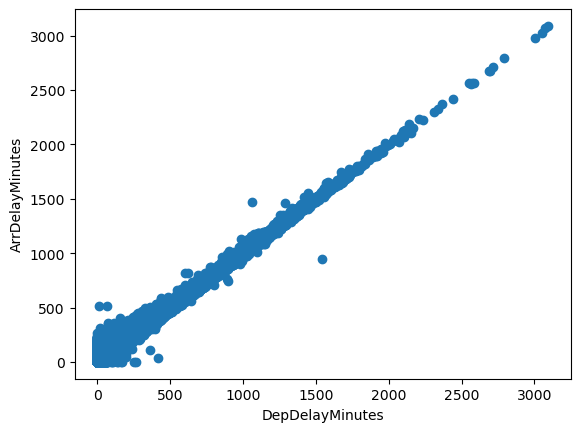

In [26]:
# Arrival delay is strongly linearly correlated with departure delay.
# Consider using Arrival Delay only. We probably care more about arrival delay than departure delay (if key stakeholders are passengers).
plt.scatter(df_relevant_nonull.DepDelayMinutes, df_relevant_nonull.ArrDelayMinutes)
plt.xlabel('DepDelayMinutes')
plt.ylabel('ArrDelayMinutes')
plt.show()

In [27]:
DepartureDelayGroups_table = df_relevant_nonull.DepartureDelayGroups.value_counts().sort_index()
DepartureDelayGroups_table

DepartureDelayGroups
-2.0       30396
-1.0     3798707
 0.0     1288663
 1.0      388704
 2.0      199691
 3.0      122998
 4.0       82504
 5.0       58181
 6.0       43344
 7.0       32759
 8.0       25203
 9.0       19763
 10.0      15840
 11.0      12683
 12.0      66434
Name: count, dtype: int64

In [28]:
ArrivalDelayGroups_table = df_relevant_nonull.ArrivalDelayGroups.value_counts().sort_index()
ArrivalDelayGroups_table

ArrivalDelayGroups
-2.0     1583783
-1.0     2466704
 0.0     1067324
 1.0      401559
 2.0      199467
 3.0      119535
 4.0       79751
 5.0       56743
 6.0       42103
 7.0       31781
 8.0       24765
 9.0       19838
 10.0      15457
 11.0      12258
 12.0      64802
Name: count, dtype: int64

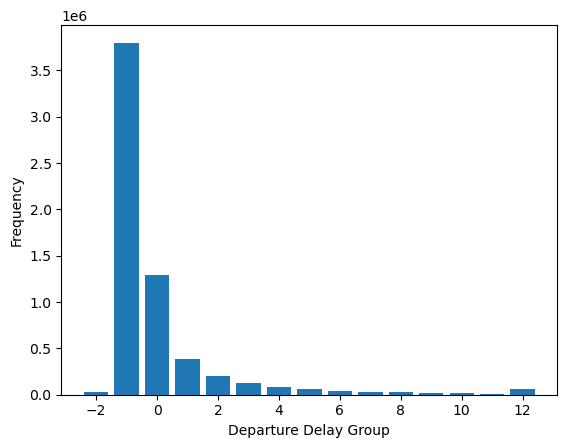

In [29]:
plt.bar(DepartureDelayGroups_table.index, DepartureDelayGroups_table.values)
plt.xlabel('Departure Delay Group')
plt.ylabel('Frequency')
plt.show()

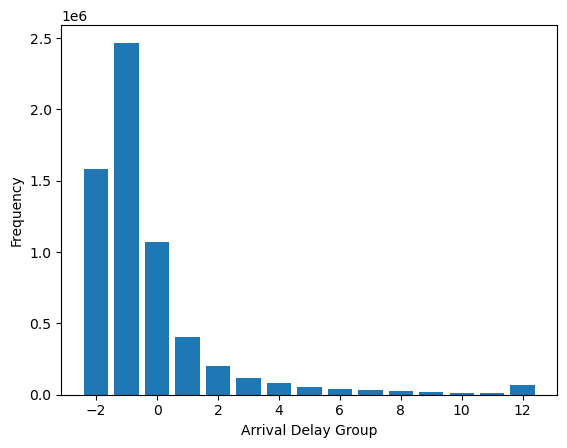

In [30]:
plt.bar(ArrivalDelayGroups_table.index, ArrivalDelayGroups_table.values)
plt.xlabel('Arrival Delay Group')
plt.ylabel('Frequency')
plt.show()

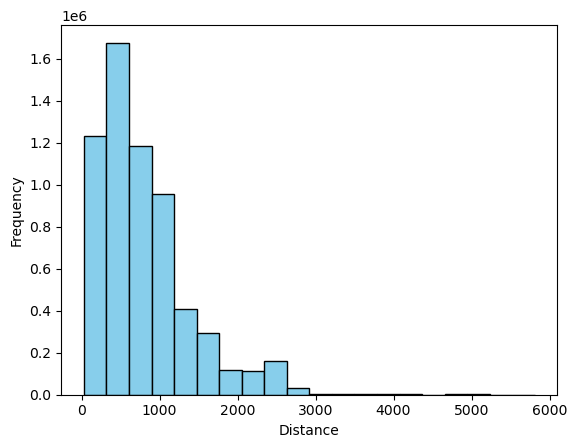

In [31]:
# distance is right skewed
plt.hist(df_relevant_nonull.Distance, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

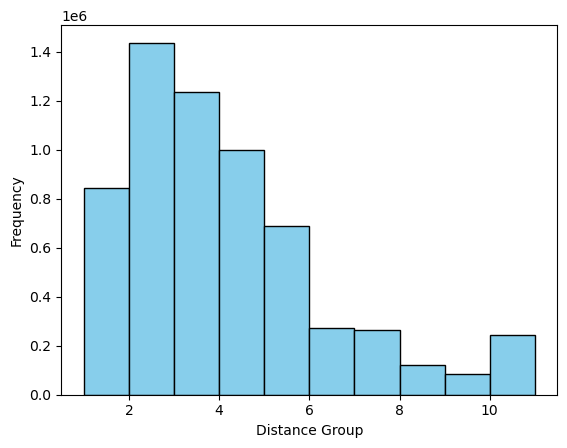

In [32]:
# distance is right skewed
plt.hist(df_relevant_nonull.DistanceGroup, color='skyblue', edgecolor='black')
plt.xlabel('Distance Group')
plt.ylabel('Frequency')
plt.show()

In [33]:
df_relevant_nonull_numerical = df_relevant_nonull.select_dtypes(include='number')
df_relevant_nonull_numerical.shape

(6185870, 22)

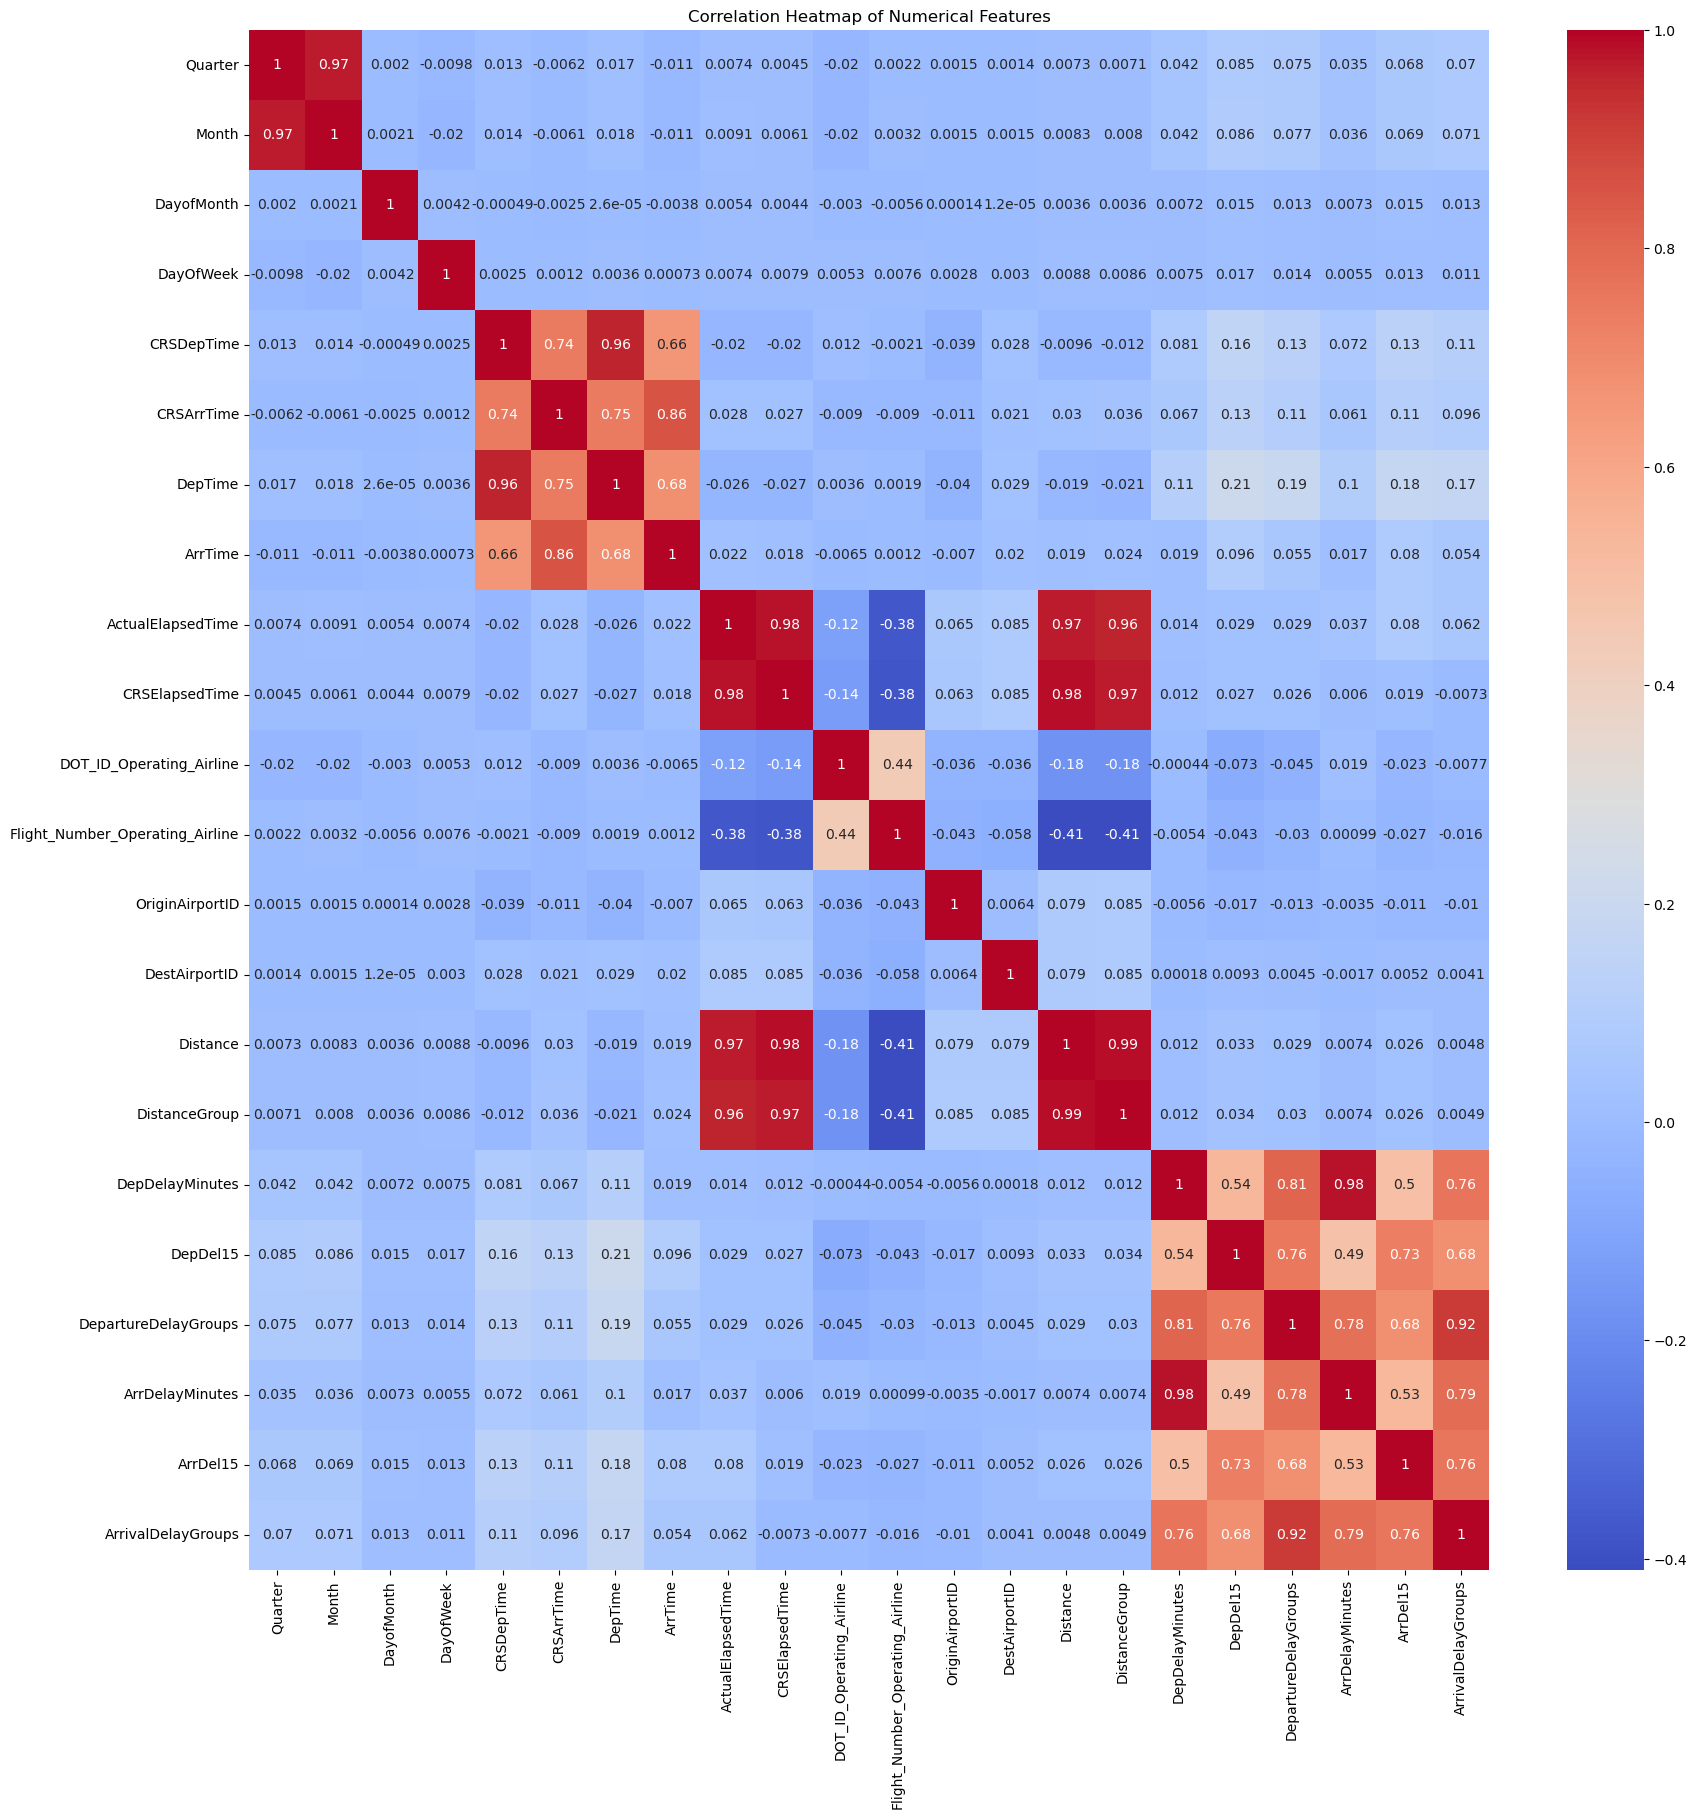

In [34]:
# check correlation
correlation_matrix_scores = df_relevant_nonull_numerical.corr()

# Plot heatmap of correlations
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix_scores, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

When selecting the following features, select only 1 feature in each group due to correlation (or because they basically mean the same thing):  

1. Quarter & Month
2. CRSDepTime & CRSArrTime
3. DOT_ID_Operating_Airline, Operating_Airline, Airline
4. OriginAirportID, Origin, OriginCityName
5. DestAirportID, Dest, DestCityName
6. Distance & DistanceGroup


When selecting a target variable, select 1 based on your type of prediction:

1. Continuous Prediction: ArrDelayMinutes
2. Binary Prediction: ArrDel15
3. Categorical Prediction: ArrivalDelayGroups

In [35]:
# This may take a while. (2-3 minutes)
df_relevant_nonull.to_csv('Cleaned_Combined_Flights_2021.csv')

# FEATURE ENGINEERING

### New Features

In [36]:
# Create a new categorical variable for Weekdays vs. Weekends
def weekday_or_weekend(day):
    if day in [6, 7]:  # Saturday (6) and Sunday (7)
        return 'Weekend'
    else:
        return 'Weekday'


df_relevant_nonull = df_relevant_nonull.copy()
# Apply the function to the 'DayOfWeek' column
df_relevant_nonull['WeekdayOrWeekend'] = df_relevant_nonull['DayOfWeek'].apply(weekday_or_weekend)

In [37]:
df_relevant_nonull['FlightDate'] = pd.to_datetime(df_relevant_nonull['FlightDate'])

# Extract useful time-based features
df_relevant_nonull['Season'] = df_relevant_nonull['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                              'Spring' if x in [3, 4, 5] else
                                              'Summer' if x in [6, 7, 8] else
                                              'Fall')  # Add season based on the month

In [38]:
# Create a uniform time scale (minutes)
def time_to_minutes(time):
    # Extract hours and minutes, handling edge cases like NaN
    if pd.isnull(time):
        return 0
    hours = time // 100
    minutes = time % 100
    return hours * 60 + minutes

# Apply the conversion
df_relevant_nonull['CRSDepTimeMinutes'] = df_relevant_nonull['CRSDepTime'].apply(time_to_minutes)
df_relevant_nonull['DepTimeMinutes'] = df_relevant_nonull['DepTime'].apply(time_to_minutes)

# Calculate Arr_deviation
# 1. Departure Deviation
df_relevant_nonull['DepDeviation'] = df_relevant_nonull['DepTimeMinutes'] - df_relevant_nonull['CRSDepTimeMinutes']

# 2. In-Flight Duration Deviation
df_relevant_nonull['DurationDeviation'] = df_relevant_nonull['ActualElapsedTime'] - df_relevant_nonull['CRSElapsedTime']

# Combine both to calculate Arr_deviation
df_relevant_nonull['Arr_deviation'] = df_relevant_nonull['DepDeviation'] + df_relevant_nonull['DurationDeviation']

#Drop irrelevant columns
df_relevant_nonull.drop(['DepDeviation', 'DurationDeviation'], axis=1, inplace=True)

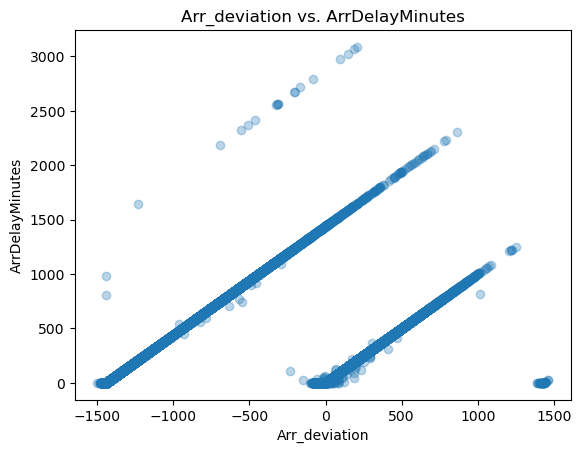

In [39]:
#Assess correlation of new feature
# Scatter plot of Arr_deviation vs ArrDelayMinutes
plt.scatter(df_relevant_nonull['Arr_deviation'], df_relevant_nonull['ArrDelayMinutes'], alpha=0.3)
plt.xlabel('Arr_deviation')
plt.ylabel('ArrDelayMinutes')
plt.title('Arr_deviation vs. ArrDelayMinutes')
plt.show()

In [40]:
#Low correlation, hence to provide more predictive benefits
correlation = df_relevant_nonull[['Arr_deviation', 'ArrDelayMinutes']].corr()
print(correlation)

                 Arr_deviation  ArrDelayMinutes
Arr_deviation         1.000000         0.133804
ArrDelayMinutes       0.133804         1.000000


In [41]:
#Proxy for Tail_number

# Avg number of delay minutes per aircraft (Tail_Number)
avg_delays_per_aircraft = df_relevant_nonull.groupby('Tail_Number')['DepDelayMinutes'].mean()

# Map the average delay back to the original DataFrame
df_relevant_nonull['AvgDelaysPerAircraft'] = df_relevant_nonull['Tail_Number'].map(avg_delays_per_aircraft)

# Replace NaN with 0 for aircraft with no recorded delays
df_relevant_nonull['AvgDelaysPerAircraft'].fillna(0, inplace=True)

/var/folders/nl/mnt6ztzx2gn41gxt1gp0ll740000gn/T/ipykernel_18528/1855091234.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_relevant_nonull['AvgDelaysPerAircraft'].fillna(0, inplace=True)


In [42]:
# Total number of flights per airline
total_flights_per_airline = df_relevant_nonull['Airline'].value_counts()

# Count the number of unique flight dates
unique_flight_dates = df_relevant_nonull['FlightDate'].nunique()

# Calculate the average number of flights per day for each airline
avg_flights_per_day_per_airline = total_flights_per_airline / unique_flight_dates

# Map the average flights per day back to the original DataFrame
df_relevant_nonull['AvgFlightsPerDay'] = df_relevant_nonull['Airline'].map(avg_flights_per_day_per_airline)


In [43]:
#Proxy feature for categorical airport features

total_flights = len(df_relevant_nonull)

# Total number of flights per Origin airport
origin_capacity = df_relevant_nonull.groupby('Origin')['FlightDate'].count().reset_index()
origin_capacity.rename(columns={'FlightDate': 'TotalFlightsFromOrigin'}, inplace=True)

# Merge Origin capacity
df_relevant_nonull = df_relevant_nonull.merge(origin_capacity, on='Origin', how='left')
df_relevant_nonull.rename(columns={'TotalFlightsFromOrigin': 'Origin_capacity'}, inplace=True)
df_relevant_nonull['Origin_capacity'] = (df_relevant_nonull['Origin_capacity']/total_flights).round(4)


# Total number of flights for each destination airport
dest_capacity = df_relevant_nonull.groupby('Dest')['FlightDate'].count().reset_index()
dest_capacity.rename(columns={'FlightDate': 'TotalFlightsToDest'}, inplace=True)

# Merge Destination capacity
df_relevant_nonull = df_relevant_nonull.merge(dest_capacity, on='Dest', how='left')
df_relevant_nonull.rename(columns={'TotalFlightsToDest': 'Dest_capacity'}, inplace=True)
df_relevant_nonull['Dest_capacity'] = (df_relevant_nonull['Dest_capacity']/total_flights).round(4)

### One-Hot Encoding

In [44]:
df_relevant_nonull = pd.get_dummies(df_relevant_nonull, columns=['WeekdayOrWeekend'], prefix='Is')

#Keep only is_Weekend due to perfect correlation?
#df_relevant_nonull = df_relevant_nonull.drop(columns=['Is_Weekday'])

In [45]:
# One-hot encode the 'Season' column
df_relevant_nonull = pd.get_dummies(df_relevant_nonull, columns=['Season'], prefix='Is')

In [46]:
categorical_columns = df_relevant_nonull.select_dtypes(include=['object'])
print(categorical_columns.head())

  Operating_Airline                Airline Tail_Number Origin  \
0                OO  SkyWest Airlines Inc.      N728SK    SGU   
1                OO  SkyWest Airlines Inc.      N752SK    PHX   
2                OO  SkyWest Airlines Inc.      N766SK    MHT   
3                OO  SkyWest Airlines Inc.      N752EV    DFW   
4                OO  SkyWest Airlines Inc.      N715SK    PHX   

          OriginCityName OriginStateName Dest  \
0         St. George, UT            Utah  PHX   
1            Phoenix, AZ         Arizona  SGU   
2         Manchester, NH   New Hampshire  ORD   
3  Dallas/Fort Worth, TX           Texas  TRI   
4            Phoenix, AZ         Arizona  BFL   

                         DestCityName DestStateName  
0                         Phoenix, AZ       Arizona  
1                      St. George, UT          Utah  
2                         Chicago, IL      Illinois  
3  Bristol/Johnson City/Kingsport, TN     Tennessee  
4                     Bakersfield, CA    Cal

In [47]:
#View unique values
# df_relevant_nonull['Operating_Airline'].value_counts()

In [48]:
# One-hot encode the 'Operating Arline' column
df_relevant_nonull = pd.get_dummies(df_relevant_nonull, columns=['Airline'])

In [49]:
df_relevant_nonull.tail()

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,DepTime,ArrTime,ActualElapsedTime,CRSElapsedTime,...,"Airline_GoJet Airlines, LLC d/b/a United Express",Airline_Hawaiian Airlines Inc.,Airline_Horizon Air,Airline_JetBlue Airways,Airline_Mesa Airlines Inc.,Airline_Republic Airlines,Airline_SkyWest Airlines Inc.,Airline_Southwest Airlines Co.,Airline_Spirit Air Lines,Airline_United Air Lines Inc.
6185865,2,6,1,2,1255,1430,1301.0,1421.0,80.0,95.0,...,False,False,False,False,False,False,False,True,False,False
6185866,2,6,1,2,730,900,727.0,845.0,78.0,90.0,...,False,False,False,False,False,False,False,True,False,False
6185867,2,6,1,2,800,1110,757.0,1101.0,124.0,130.0,...,False,False,False,False,False,False,False,True,False,False
6185868,2,6,1,2,1300,1620,1252.0,1559.0,127.0,140.0,...,False,False,False,False,False,False,False,True,False,False
6185869,2,6,1,2,1925,2055,1948.0,2116.0,88.0,90.0,...,False,False,False,False,False,False,False,True,False,False


In [50]:
#Find a proxy for arrival and destination states to encode patterns other than airport capacity.


In [51]:
df_relevant_nonull.drop(['Tail_Number', 'OriginCityName', 'Origin', 'OriginStateName'
                        , 'Dest', 'DestCityName', 'DestStateName', 'Operating_Airline', 'FlightDate']
                        , axis=1, inplace=True)

In [52]:
df_relevant_nonull.to_csv('Transformed_Combined_Flights_2021.csv')

### TEST TRAIN SPLIT

In [53]:
# Remove all features that directly relate to delay to ensures the model is not learning from target-related features.
X = (df_relevant_nonull
     .drop(columns=['ArrDelayMinutes',  # Actual delay in minutes (target leakage)
                    'ArrDel15',         # Binary indicator for >15-minute delay (target)
                    'ArrivalDelayGroups',  # Delay grouped into intervals (target leakage)
                    'Arr_deviation',    # Deviation in arrival time (derived from delays)
                    'DepDelayMinutes',  # Departure delay in minutes (target leakage)
                    'DepDel15',         # Binary indicator for >15-minute departure delay
                    'DepartureDelayGroups'  # Departure delay grouped into intervals
                   ])
    )  # Final feature set

y = df_relevant_nonull['ArrDel15']  # Target Var

#used random stratification because of class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include='bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include='bool').columns})

In [54]:
# distribution in both training and testing sets
print("Training has:")
print(y_train.value_counts(normalize=True))

print("\nTesting has:")
print(y_test.value_counts(normalize=True))

Training has:
ArrDel15
0.0    0.827339
1.0    0.172661
Name: proportion, dtype: float64

Testing has:
ArrDel15
0.0    0.827339
1.0    0.172661
Name: proportion, dtype: float64


### Standardization

In [55]:
#Change all hh:mm time columns to minutes??
# df_relevant_nonull.info()

In [56]:
standard_scaler = StandardScaler()

numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Create a copy of the original X_train and X_test for standardization
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[numerical_cols] = standard_scaler.fit_transform(X_train_std[numerical_cols])
X_test_std[numerical_cols] = standard_scaler.transform(X_test_std[numerical_cols])

# MODEL SELECTION - Model 1

In [57]:
# Baseline Model 1A
# Accuracy if we predict majority class is 82%, aiming to achieve higher accuracy than this.

#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression with class balancing
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=500)

# Fit on standardized data
lr.fit(X_train_std, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_std)
y_pred_prob_lr = lr.predict_proba(X_test_std)[:, 1]  # Probability for class 1

# Evaluate
print("Logistic Regression Metrics")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Metrics
Accuracy: 0.7575805828444503
Precision: 0.3912032776552159
Recall: 0.7263683688182312
F1 Score: 0.5085270149138778
ROC-AUC Score: 0.8166808820734203

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.76      0.84   1023562
         1.0       0.39      0.73      0.51    213612

    accuracy                           0.76   1237174
   macro avg       0.66      0.75      0.67   1237174
weighted avg       0.84      0.76      0.78   1237174



Decision Tree Metrics
Accuracy: 0.749750641381083
Precision: 0.35376384056160537
Recall: 0.5435368799505645
F1 Score: 0.4285825024824017
ROC-AUC Score: 0.7262288356094835

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.79      0.84   1023562
         1.0       0.35      0.54      0.43    213612

    accuracy                           0.75   1237174
   macro avg       0.62      0.67      0.63   1237174
weighted avg       0.80      0.75      0.77   1237174



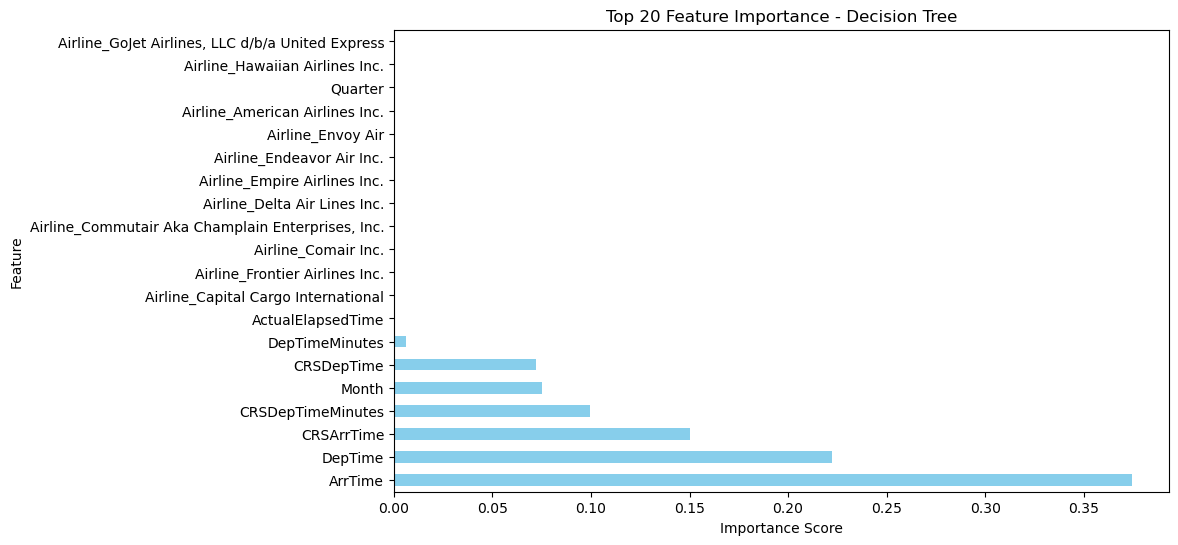

In [58]:
# Baseline Model 1B
#DECISION TREE (with feature importance)

dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)

# Fit the model on the training data
dt.fit(X_train, y_train)

# Predictions on the test set
y_pred_dt = dt.predict(X_test)
y_pred_prob_dt = dt.predict_proba(X_test)[:, 1]  # Probability for class 1

# Evaluate the model
print("Decision Tree Metrics")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

# Feature Importance
feature_importance = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_importance.head(20).plot(kind='barh', color='skyblue')
plt.title("Top 20 Feature Importance - Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed: 844.4min


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   11.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   10.8s


Random Forest Metrics
Accuracy: 0.9542618904050684
Precision: 0.8554844201356503
Recall: 0.8845195962773627
F1 Score: 0.8697597554744357
ROC-AUC Score: 0.9863992890527016

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.97   1023562
         1.0       0.86      0.88      0.87    213612

    accuracy                           0.95   1237174
   macro avg       0.92      0.93      0.92   1237174
weighted avg       0.95      0.95      0.95   1237174



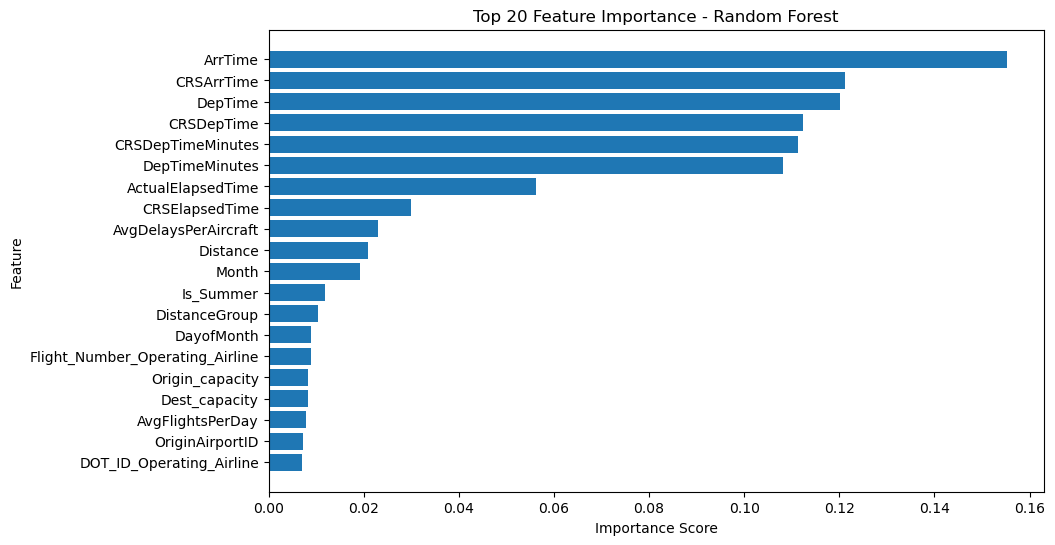

In [60]:
# Baseline Model 1C (Takes ~10 minutes)
# RANDOM FOREST CLASSIFIER

rf = RandomForestClassifier(
    n_estimators=100, max_depth=20,class_weight='balanced',random_state=42, verbose=3)

# Fit
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]  # Probability for class 1

# Evaluate
print("Random Forest Metrics")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Feature Importance Visualization
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance - Random Forest")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# precision = of the flights that were predicted to be delayed, how many were actually delayed?
# recall = of all the delayed flights, how many were predicted to be delayed?
# F-1 = balance between precision and recall 

# Metrics Evaluation - Random Forest


In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import RandomizedSearchCV

### Classification Report - Baseline Random Forest Model

In [75]:
class_report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(class_report_rf)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97   1023562
         1.0       0.86      0.88      0.87    213612

    accuracy                           0.95   1237174
   macro avg       0.92      0.93      0.92   1237174
weighted avg       0.95      0.95      0.95   1237174



### Confusion Matrix - Baseline Random Forest Model

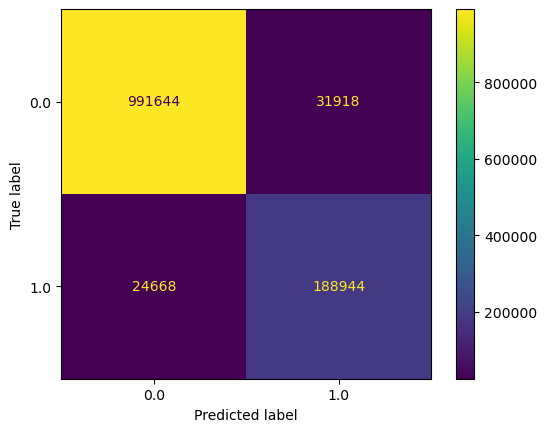

In [73]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=lr.classes_)
disp.plot()
plt.show() # Hide label

### ROC Curve - Baseline Random Forest Model

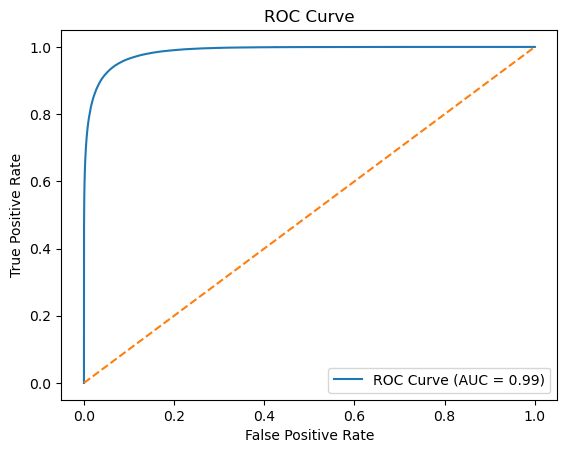

In [68]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf) # Plot ROC
roc_auc_rf = auc(fpr_rf, tpr_rf) # Plot AUC 

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--') # Random classifier 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Feature Selection & Remodeling 

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed: 11.2min


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   12.7s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   11.7s


Random Forest Metrics
Accuracy: 0.754817026545983
Precision: 0.36084261855721267
Recall: 0.544571466022508
F1 Score: 0.4340656880377919
ROC-AUC Score: 0.7431121458001962

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.80      0.84   1023562
         1.0       0.36      0.54      0.43    213612

    accuracy                           0.75   1237174
   macro avg       0.63      0.67      0.64   1237174
weighted avg       0.80      0.75      0.77   1237174



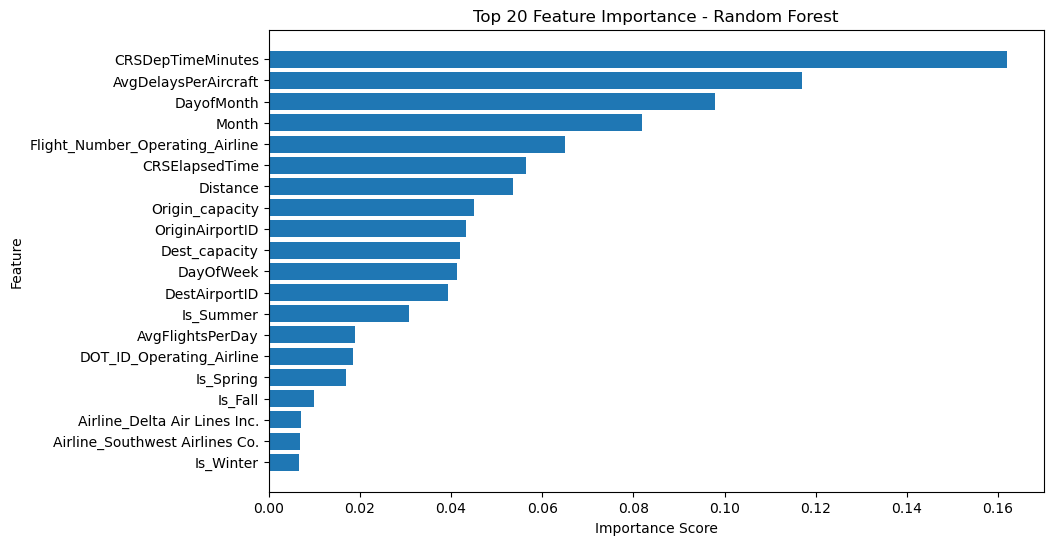

In [83]:
X_clean_rf = (X.drop(columns=['Quarter',  # Higly correlated with month
                    'DistanceGroup',  # Higly correlated with distance
                    'ActualElapsedTime', # Higly correlated with CRSElapsedTime
                    'CRSDepTime',  # will keep crsdeptimeminutes
                    'DepTimeMinutes', 
                    'ArrTime',   # will not normally be known
                    'DepTime',   # will not normally be known
                    'CRSArrTime'  # highly correlated with CRSDepTime
                   ]))

# New train-test split with X_clean_rf (same code as earlier)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_clean_rf, y, test_size=0.2, random_state=42, stratify=y)

X_train_rf = X_train_rf.astype({col: 'int' for col in X_train_rf.select_dtypes(include='bool').columns})
X_test_rf = X_test_rf.astype({col: 'int' for col in X_test_rf.select_dtypes(include='bool').columns})

rf_2 = RandomForestClassifier(n_estimators=100, max_depth=20,class_weight='balanced',random_state=42, verbose=3)

# Fit
rf_2.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_rf_2 = rf_2.predict(X_test_rf)
y_pred_prob_rf_2 = rf_2.predict_proba(X_test_rf)[:, 1]  # Probability for class 1

# Evaluate
print("Random Forest Metrics")
print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf_2))
print("Precision:", precision_score(y_test_rf, y_pred_rf_2))
print("Recall:", recall_score(y_test_rf, y_pred_rf_2))
print("F1 Score:", f1_score(y_test_rf, y_pred_rf_2))
print("ROC-AUC Score:", roc_auc_score(y_test_rf, y_pred_prob_rf_2))
print("\nClassification Report:\n", classification_report(y_test_rf, y_pred_rf_2))

# Feature Importance Visualization
feature_importances = pd.DataFrame({
    'Feature': X_train_rf.columns,
    'Importance': rf_2.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance - Random Forest")
plt.gca().invert_yaxis()
plt.show()

### Classification Report - Baseline Model Post-Feature Selection

In [84]:
class_report_rf = classification_report(y_test_rf, y_pred_rf_2)
print("Classification Report:")
print(class_report_rf)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84   1023562
         1.0       0.36      0.54      0.43    213612

    accuracy                           0.75   1237174
   macro avg       0.63      0.67      0.64   1237174
weighted avg       0.80      0.75      0.77   1237174



### Confusion Matrix - Baseline Model Post-Feature Selection

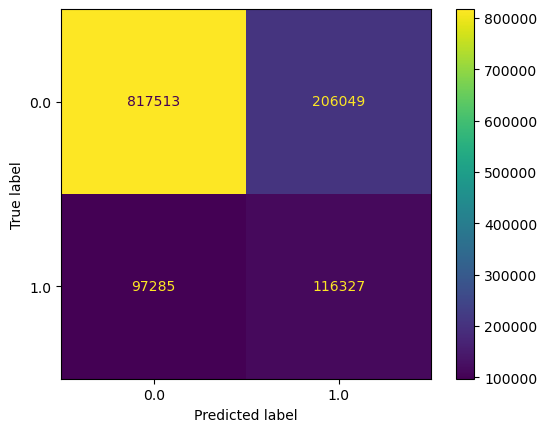

In [86]:
cm_rf_2 = confusion_matrix(y_test_rf, y_pred_rf_2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_2, display_labels=lr.classes_)
disp_2.plot()
plt.show() # Hide label

### ROC Curve - Baseline Model Post-Feature Selection

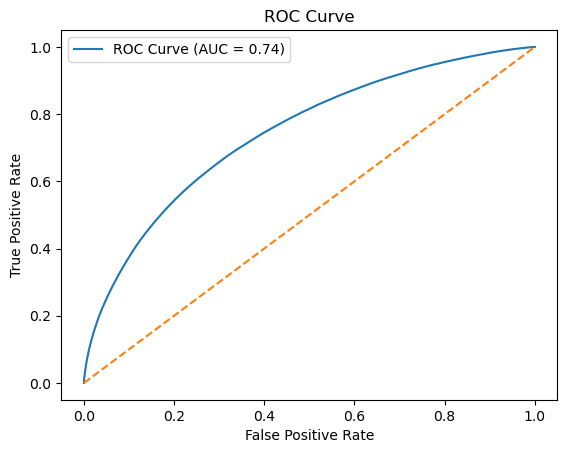

In [87]:
fpr_rf_2, tpr_rf_2, _ = roc_curve(y_test_rf, y_pred_prob_rf_2) # Plot ROC 
roc_auc_rf_2 = auc(fpr_rf_2, tpr_rf_2) # Plot AUC

plt.figure()
plt.plot(fpr_rf_2, tpr_rf_2, label=f'ROC Curve (AUC = {roc_auc_rf_2:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--') # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Hyperparameter Tuning - RandomizedSearchCV for ROC-AUC

In [88]:
# Using a subset of the training data for faster fitting
X_train_sub_rf, _, y_train_sub_rf, _ = train_test_split(X_train_rf, y_train_rf, test_size=0.8, random_state=42)

# Define the parameter grid
param_grid_2 = {
    'n_estimators': [100, 200],          
    'max_depth': [10, 20, 30, None],          
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2],            
    'max_features': ['sqrt', 'log2', None],   
}

# Perform RandomizedSearchCV
random_search_2 = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_grid_2,
    n_iter=10,  
    cv=2,  
    scoring='roc_auc', # Optimize ROC-AUC 
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=2  # Show progress
)

# Fit the model
random_search_2.fit(X_train_sub_rf, y_train_sub_rf)

# Print the best parameters and performance
print("Best Parameters:", random_search_2.best_params_)
print("Best ROC-AUC Score:", random_search_2.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 8.3min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 8.5min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.2min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.1min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=13.1min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=13.1min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.3min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators

### Hyperparameter Tuning - RandomizedSearchCV for F-1

In [93]:
# Using a subset of the training data for faster fitting
X_train_sub_rf_2, _, y_train_sub_rf_2, _ = train_test_split(X_train_rf, y_train_rf, test_size=0.6, random_state=42)

# Define the parameter grid
param_grid_2 = {
    'n_estimators': [100, 200],          
    'max_depth': [10, 20, 30, None],          
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2],            
    'max_features': ['sqrt', 'log2', None],   
}

# Perform RandomizedSearchCV
random_search_3 = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_grid_2,
    n_iter=10,  
    cv=2,  
    scoring='f1', # Optimize F-1 score
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=2  # Show progress
)

# Fit the model
random_search_3.fit(X_train_sub_rf_2, y_train_sub_rf_2)

# Print the best parameters and performance
print("Best Parameters:", random_search_3.best_params_)
print("Best F-1 Score:", random_search_3.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=18.6min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=18.6min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=10.3min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=10.3min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=30.1min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=30.1min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 8.1min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators

### New Random Forest Model with Tuned Hyperparameters (ROC-AUC)

In [96]:
rf_tuned = RandomForestClassifier(
    n_estimators=200, max_depth=None, min_samples_leaf=5, min_samples_split=5, max_features='sqrt', class_weight='balanced', random_state=42, verbose=3)

# Fit
rf_tuned.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_rf_tuned = rf_tuned.predict(X_test_rf)
y_pred_prob_rf_tuned = rf_tuned.predict_proba(X_test_rf)[:, 1]  # Probability for class 1

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed: 12.7min


building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73

KeyboardInterrupt: 

In [90]:
# Evaluate
print("Random Forest Metrics")
print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf_tuned))
print("Precision:", precision_score(y_test_rf, y_pred_rf_tuned))
print("Recall:", recall_score(y_test_rf, y_pred_rf_tuned))
print("F1 Score:", f1_score(y_test_rf, y_pred_rf_tuned))
print("ROC-AUC Score:", roc_auc_score(y_test_rf, y_pred_prob_rf_tuned))
print("\nClassification Report:\n", classification_report(y_test_rf, y_pred_rf_tuned))

Random Forest Metrics
Accuracy: 0.809052728233862
Precision: 0.4455782803862419
Recall: 0.43355710353350935
F1 Score: 0.4394855039968111
ROC-AUC Score: 0.7580196456720883

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.88   1023562
         1.0       0.45      0.43      0.44    213612

    accuracy                           0.81   1237174
   macro avg       0.66      0.66      0.66   1237174
weighted avg       0.81      0.81      0.81   1237174



### Determining the Optimal Threshold (Best F-1)

In [94]:
#Determine Optimal Threshold

# Generate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_rf, y_pred_prob_rf_tuned)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = f1_scores[:-1]  # Excluding the last score since it has no corresponding threshold

# Find the index of the best F1 score
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold}, Best F1 Score: {f1_scores[best_idx]}")

Best Threshold: 0.4413084010823967, Best F1 Score: 0.45220995191377583


In [95]:
# Apply the best threshold
custom_preds = (y_pred_prob_lr >= best_threshold).astype(int)

# Evaluate performance
print("Metrics at Best Threshold")
print("Accuracy:", accuracy_score(y_test_rf, custom_preds))
print("Precision:", precision_score(y_test_rf, custom_preds))
print("Recall:", recall_score(y_test_rf, custom_preds))
print("F1 Score:", f1_score(y_test_rf, custom_preds))

Metrics at Best Threshold
Accuracy: 0.6958228996083009
Precision: 0.3375071405459172
Recall: 0.7910463831619946
F1 Score: 0.47314335955109665
